In [1]:

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
def getPortsData(df: pd.DataFrame, origin_port: str, destination_port_city: str,
                 destination_port_country: str) -> pd.Series:
    # streamline data so it has route and date column
    df['Route'] = df['AustralianPort'] + ' <-> ' + df['ForeignPort'] + ' (' + df['Country'] + ')'
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str) + '-01')

    # build route string using the provided destination country
    route_str = f"{origin_port} <-> {destination_port_city} ({destination_port_country})"

    route_df = df[df['Route'] == route_str].copy()
    time_series = route_df.set_index('Date')['Passengers_Total'].sort_index()

    # Add route info as name attribute
    time_series.name = route_str

    return time_series

Forecasted passenger traffic for 1989-07 to 1990-12:
Month 07: 54,705 passengers
Month 08: 54,023 passengers
Month 09: 54,021 passengers
Month 10: 55,268 passengers
Month 11: 48,776 passengers
Month 12: 52,595 passengers
Month 13: 56,945 passengers
Month 14: 40,492 passengers
Month 15: 46,126 passengers
Month 16: 36,187 passengers
Month 17: 33,174 passengers
Month 18: 29,579 passengers
Month 19: 43,795 passengers
Month 20: 43,100 passengers
Month 21: 43,024 passengers
Month 22: 44,632 passengers
Month 23: 38,405 passengers
Month 24: 42,639 passengers


/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


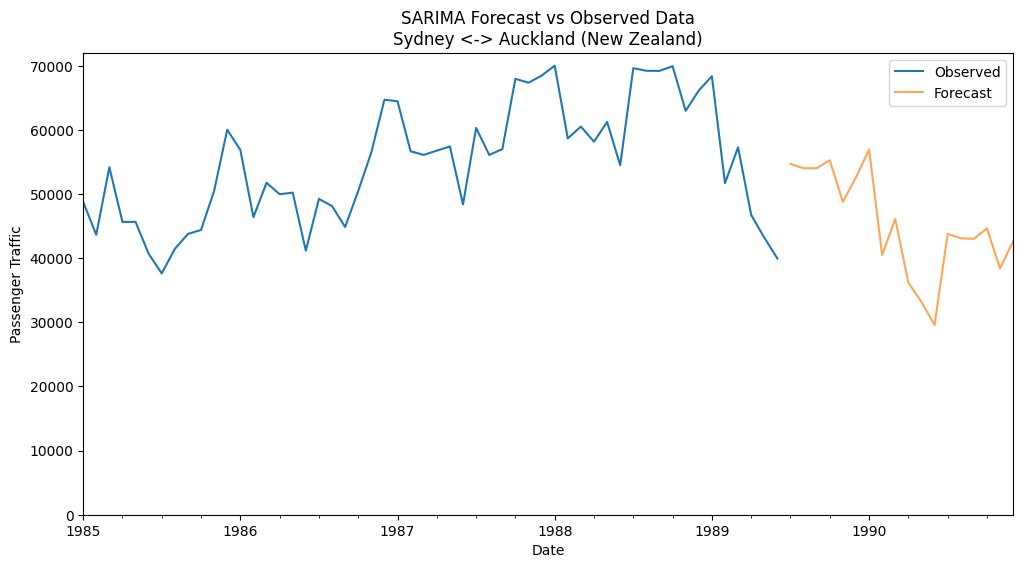

In [15]:
def runModel(time_series: pd.Series, train_end: str, test_start: str, test_end: str,
             order: tuple = (1,1,1), seasonal_order: tuple = (1,1,1,12)) -> dict:
    #order: (p=1, d=1, q=1):
    #   p=1: use 1 previous month to predict current
    #   d=1: use first differencing to remove trend
    #   q=1: use 1 previous error term for smoothing

    #seasonal_order: (P=1, D=1, Q=1, s=12) where:
    #   P=1: use same month from 1 previous year
    #   D=1: use seasonal differencing to remove yearly patterns
    #   Q=1: use 1 previous seasonal error term
    #   s=12: 12-month seasonal cycle
    #https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/#

    # train on all data up to train_end
    train = time_series[:train_end]

    # see if test data exists in our dataset
    try:
        test = time_series[test_start:test_end]
        has_test_data = len(test) > 0
    except:
        has_test_data = False
        test = None

    # create and train the SARIMA model using specified parameters
    model = sm.tsa.statespace.SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False, #allow data to have overall trend like growth
        enforce_invertibility=True #setting True puts more weight in recent events like strike
    )
    results = model.fit(disp=False)

    # predict the test period
    predictions = results.get_prediction(
        start=pd.to_datetime(test_start + '-01'),
        end=pd.to_datetime(test_end + '-01'),
        dynamic=False
    )
    pred_mean = predictions.predicted_mean

    # Only calculate accuracy if we have actual test data
    if has_test_data and test is not None:
        monthly_accuracy = {}
        start_month = int(test_start.split('-')[1])

        for i in range(len(test)):
            month = start_month + i
            if i < len(pred_mean):
                actual = test.iloc[i]
                pred = pred_mean.iloc[i]
                monthly_accuracy[month] = 1 - abs(actual - pred) / actual

        print(f"Monthly standardized accuracy for {test_start} to {test_end}:")
        for month, acc in monthly_accuracy.items():
            print(f"Month {month:02d}: Accuracy ≈ {acc:.4f}")
    else:
        # only show forecast values when no test data exists
        print(f"Forecasted passenger traffic for {test_start} to {test_end}:")
        start_month = int(test_start.split('-')[1])

        for i, pred in enumerate(pred_mean):
            month = start_month + i
            print(f"Month {month:02d}: {pred:,.0f} passengers")

    # plot results
    ax = time_series.plot(label='Observed', figsize=(12, 6))
    pred_mean.plot(ax=ax, label='Forecast', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_ylabel('Passenger Traffic')
    plt.title(f'SARIMA Forecast vs Observed Data\n{time_series.name}')
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()

    # Return appropriate data
    return monthly_accuracy if has_test_data else pred_mean
#use this time frame if you want to actually predict attendance in the future as specified in the instructions(6-12 months in advance). you can change
#test_end to increase or decrease this range.
train_end, test_start, test_end ='1989-07','1989-07', '1990-12'

#this is for training the model on the given data but also testing it on the same data but in a later year so we can
#validate its accuracy. right now it gets trained up until the beginning of 1988 and gets tested on the entirety of 1988
#train_end, test_start, test_end ='1987-12','1988-01', '1988-12'
monthly_acc = runModel(ts, train_end, test_start, test_end)

In [3]:
df = pd.read_csv('data/AeroConnectData.csv')

ts = getPortsData(df, 'Sydney', 'Auckland', 'New Zealand')

monthly_acc = runModel(ts)


NameError: name 'runModel' is not defined